In [1]:
import pickle
import numpy as np
import os
from tqdm import tqdm

#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

import joblib

2023-08-17 16:46:52.487772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 16:46:53.265897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # load dataset
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
# !unzip -qq Flickr8k_Dataset.zip
# !unzip -qq Flickr8k_text.zip
# !rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [4]:
WORK_DIR = './'
BASE_DIR = './'

### EXTRACT IMAGE FEATURES

In [5]:
#load Model
model = MobileNet()

# change Archi
model = Model(model.input, model.layers[-2].output)

model.summary()

2023-08-17 16:46:55.580808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 16:46:55.628180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 16:46:55.628431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [6]:
#extract Features from image
features ={}
directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]2023-08-17 16:46:57.371238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-17 16:46:57.459113: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-17 16:46:57.460757: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-17 16:46:57.460833: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-17 16:46:57.462708: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-17 16:46:57.462790: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PA

In [7]:
# saving
with open('./features2.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load features form pickle
with open(os.path.join(WORK_DIR, 'features2.pickle'), "rb") as f:
  features = pickle.load(f)

### EXTRACT CAPTION FEATURES

In [8]:
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt')) as f:
  captions_doc = f.read()

In [9]:
## Mapping 

mapping = {}

for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split('\t')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('#')[0].split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40461/40461 [00:00<00:00, 563755.86it/s]


In [10]:
mapping.pop('2258277193_586949ec62')

['people waiting for the subway',
 'Some people looking out windows in a large building .',
 'Three people are waiting on a train platform .',
 'Three people standing at a station .',
 'two woman and one man standing near train tracks .']

In [11]:
len(mapping)

8091

In [23]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [24]:
mapping['99679241_adc853a5c0']

['startseq grey bird stands majestically on beach while waves roll in endseq',
 'startseq large bird stands in the water on the beach endseq',
 'startseq tall bird is standing on the sand beside the ocean endseq',
 "startseq water bird standing at the ocean 's edge endseq",
 'startseq white crane stands tall as it looks out upon the ocean endseq']

In [25]:
clean(mapping)

In [26]:
mapping['99679241_adc853a5c0']

['startseq startseq grey bird stands majestically on beach while waves roll in endseq endseq',
 'startseq startseq large bird stands in the water on the beach endseq endseq',
 'startseq startseq tall bird is standing on the sand beside the ocean endseq endseq',
 "startseq startseq water bird standing at the ocean 's edge endseq endseq",
 'startseq startseq white crane stands tall as it looks out upon the ocean endseq endseq']

In [27]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [28]:
len(all_captions)

40455

In [29]:
all_captions[:10]

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq',
 'startseq startseq black dog and spotted dog are fighting endseq endseq',
 'startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq',
 'startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq',
 'startseq startseq two dogs of different breeds looking at each other on the road endseq endseq',
 'startseq startseq two dogs on pavement moving toward each other endseq endseq']

In [31]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# # store features in pickle
# pickle.dump(tokenizer, open(os.path.join(WORK_DIR, 'tokenizer2.pkl'), 'wb'))
# saving
# with open('./tokenizer2.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
joblib.dump(tokenizer, 'tokenizer2.pkl')
joblib.dump(all_captions, 'all_captions.pkl')

['all_captions.pkl']

In [20]:
vocab_size

8485

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [22]:
import json
 
# Data to be written
dictionary = {
    "vocab_size": vocab_size,
    "max_length": max_length
}
 
with open("meta_data_mobilenet.json", "w") as outfile:
    json.dump(dictionary, outfile)

### TRIAN TEST SPLIT

In [26]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### Data Generator

In [30]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0



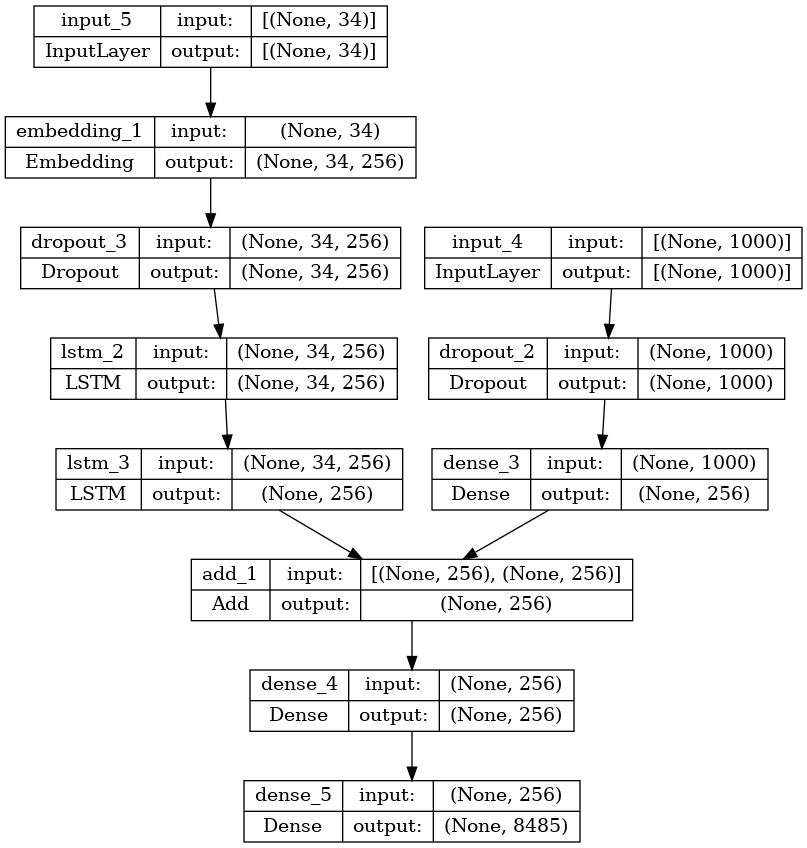

In [31]:
# encoder model
# image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
#se1 = Word2Vec(all_captions, 256, min_count=1)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se4 = LSTM(256)(se3)

# decoder model
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt)

# plot the model
plot_model(model, show_shapes=True)

In [26]:
# model.load_weights(WORK_DIR+'model_mobilenet.h5')

In [32]:
# train the model
epochs = 50
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    print(f"############################# EPOCH{i:3.0f}   ##############################")
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


############################# EPOCH  0   ##############################
455/455 [==============================] - 121s 252ms/step - loss: 5.0636
############################# EPOCH  1   ##############################
455/455 [==============================] - 119s 261ms/step - loss: 3.9588
############################# EPOCH  2   ##############################
455/455 [==============================] - 114s 251ms/step - loss: 3.5750
############################# EPOCH  3   ##############################
455/455 [==============================] - 118s 260ms/step - loss: 3.3230
############################# EPOCH  4   ##############################
455/455 [==============================] - 119s 262ms/step - loss: 3.1310
############################# EPOCH  5   ##############################
455/455 [==============================] - 115s 253ms/step - loss: 2.9750
############################# EPOCH  6   ##############################
455/455 [==============================] - 113s 248m

In [33]:
model.save(WORK_DIR+'/model_mobilenet.h5')

/home/rupesh/anaconda3/envs/img_caption/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Generating Captions for Images

In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            in_text += ' ' + 'endseq'
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            in_text += ' ' + 'endseq'
            break
      
    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [08:58<00:00,  1.50it/s]


BLEU-1: 0.459431
BLEU-2: 0.258270


In [37]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq dog is running through the yard with its tongue hanging out endseq endseq


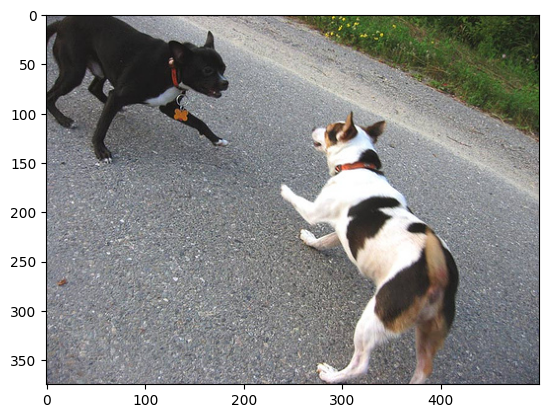

In [38]:
directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq child in pink shirt is riding her bike on the playground endseq endseq


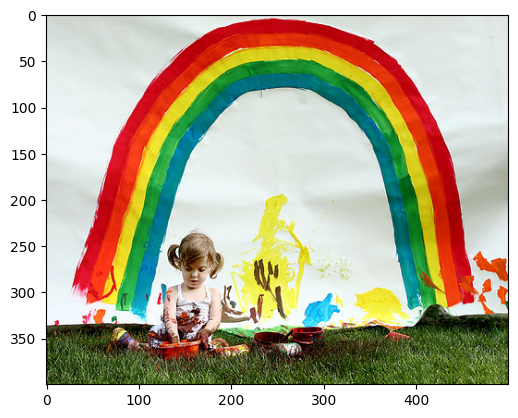

In [39]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq boy is leading donkeys on path endseq
startseq man and two pack mules walk across field in front of mountain endseq
startseq man is walking in field behind two donkeys endseq
startseq man travels with two donkeys in the mountains endseq
startseq person in blue jacket follows two donkeys along mountain trail endseq
--------------------Predicted--------------------
startseq group of hikers are hiking up hill in front of mountain covered mountains endseq endseq


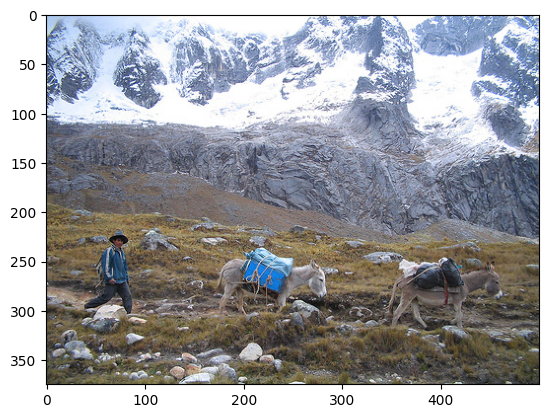

In [40]:
generate_caption("56489627_e1de43de34.jpg")

In [41]:
vocab_size

8485